# **LINEARISATION UNIQUE DES TRAFICS SUR BORDEAUX METROPOLE**
> ATTENTION : IL Y A DES MELI-MELO ENTRE LE FICHIER gdf_rhv_groupe qui contient un idtronc pour tout les troncons et a été constitué avant de prendre en compte les cat_rhv 62, 63 etc...; qui est utilisé dans toute la partie affectation points de comptage, et le fichier issus de la Bdd graph_filaire qui lui contient bien toute les lignes mais n'a pas d'idtronc renseigné.<br> il faudrait remettre tout ça à plat

In [1]:
%load_ext autoreload
%autoreload 2
import sys #c'est pas propre mais pour le moment pour importer mes modules perso dans le notebook je ne sais pas faire
sys.path.append(r'C:\Users\marti\git\Outils\Outils\Martin_Perso')
sys.path.append(r'C:\Users\marti\git\otv\otv\Transfert_Donnees')
sys.path.append(r'C:\Users\marti\git\Lin_uniq_BdxM\Lin_uniq_BdxM\Traitements')
import Connexion_Transfert as ct
import geopandas as gp
import pandas as pd
import numpy as np
from shapely import speedups #gestion erreur GEOSGeom_createLineString_r returned a NULL pointer
speedups.disable()
from shapely.geometry import MultiPoint, Polygon, box, Point
from shapely.ops import nearest_points
from shapely.wkt import dumps, loads
import re, json
from unidecode import unidecode
from copy import copy, deepcopy
from difflib import get_close_matches,SequenceMatcher
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from collections import Counter
from Outils import creer_graph, plus_proche_voisin,nb_noeud_unique_troncon_continu,verif_index, gp_changer_nom_geom

from Simplifier_Rdpt import creer_dico_noeud_rdpt,simplifier_noeud_rdpt,maj_graph_rdpt, donnees_tot_rd_pt
import Estim_trafic as et
import Comptage as Cpt
import Affectation_pt_comptage as ap
import Voies_Cat4 as v4
from MMM import import_fichiers_mmm

pd.set_option('display.max_columns', 100)
pd.set_option('display.min_rows', 30)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 50)


from Base_BdTopo.Import_outils import import_donnes_base
from Base_BdTopo.Rond_points import identifier_rd_pt
from Base_BdTopo.Regroupement_correspondance import *
from Base_BdTopo.Troncon_elementaire import *
from Base_BdTopo.Troncon_base import *
from Base_BdTopo.Gestion_2_chaussee import *
import plotly.express as px
import altair as alt

In [330]:
pd.set_option('max_colwidth', 50)

## 1 Regrouper les troncons du filaire de voie
>Les troncons du filaire de voie sont regroupés d'abord uniquement avec les troncons de cat_rhv égal à 1,2,3,61,62,63, pour pouvoir réaliser des troncon de trafic homogènes tous reliés entre eux.
<br> Ensuite, un deuxième regroupement comprenant l'ensemble des troncons de cat_rhv permetd'affiner le diagnostic

> ### 1.1 Import du fichier final
le fichier shape est vérifié à la main car l'affectation automatique n'est pas 100% fiable

In [2]:
# Pour info : lire le graph issu de la methode decrite dessous
with ct.ConnexionBdd('local_otv', localisation='maison') as c :
    graph_filaire_123 = gp.read_postgis('select * from linearisation_bm.graph_rhv_123_v2', c.connexionPsy)
    graph_filaire_123_vertex = gp.read_postgis('select id,cnt,chk,ein,eout,the_geom as geom from linearisation_bm.graph_rhv_123_v2_vertices_pgr', c.connexionPsy)
    graph_filaire = gp.read_postgis('select * from linearisation_bm.graph_rhv_complet', c.connexionPsy)
    graph_filaire_vertex=gp.read_postgis('select id,cnt,chk,ein,eout,the_geom as geom from linearisation_bm.graph_rhv_complet_vertices_pgr', c.connexionPsy)

In [3]:
gdf_rhv_groupe_123=graph_filaire_123
#gdf_rhv_groupe_123=gp.read_file(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\gdf_rhv_groupe_123_v2.shp').merge(graph_filaire_123[['ident','source','target']], on='ident', how='left')"""
gdf_rhv_groupe=gp.read_file(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\rhv_grp.shp').merge(graph_filaire[['ident','source','target']], on='ident', how='left')

>### 1.2 Méthode
 pour information

In [ ]:
# 1. import du fichier de filaire de base
gdf_rhv=gp.read_file(r'D:\temp\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_source\Bdx-Metro\Filaire_voie\FV_TRONC_L.shp')
# 2. mise en forme
gdf_rhv.columns=[a.lower() for a in gdf_rhv.columns] #nom de colonne en minuscule
gdf_rhv.rename(columns={'gid':'id','nom_voie' : 'numero'},inplace=True)
gdf_rhv=gdf_rhv.loc[~gdf_rhv.id.isna()].copy()
gdf_rhv['id_ign']=gdf_rhv.ident.apply(lambda x : 'TRONROUT'+str(x))
gdf_rhv=gdf_rhv.loc[~gdf_rhv.cat_rhv.isin(['98','99'])].copy()
gdf_rhv['nature']=gdf_rhv.apply(lambda x : 'Route à 2 chaussées' if x['rgraph_dbl']==0 else 'Route à 1 chaussée', axis=1)
gdf_rhv['nature']=gdf_rhv.apply(lambda x : 'Bretelle' if x['cat_dig']=='8' else x['nature'], axis=1)
gdf_rhv['numero']=gdf_rhv.apply(lambda x : 'Bretelle '+x['numero'] if x['cat_dig']=='8' else x['numero'], axis=1)
gdf_rhv['sens']=gdf_rhv.apply(lambda x : 'Direct' if x['rgraph_dbl']==0 else 'Double', axis=1)
gdf_rhv['codevoie_d']='NR'
gdf_rhv['importance']=gdf_rhv['cat_dig']
gdf_rhv['id']=gdf_rhv.id.apply(lambda x : int(x))
#gdf_rhv.loc[gdf_rhv.nom_voie.isna()] #verif des nom_voie null : 2 lignes, cf traitements plus loins
#filtrer les voies cylcables et autres
gdf_rhv_filtre=gdf_rhv.loc[~gdf_rhv.cat_dig.isin(['6','7','9','10'])].copy()

# 3. creer le graph en bdd
#creer_graph(gdf_rhv_filtre.loc[gdf_rhv_filtre.cat_rhv.isin(['1','2','3','33','61','62','63'])],
            #'local_otv',schema='linearisation_bm',table='graph_rhv_123',table_vertex='graph_rhv_123_vertices_pgr')
creer_graph(gdf_rhv_filtre,'local_otv',schema='linearisation_bm',table='graph_rhv_complet',table_vertex='graph_rhv_complet_vertices_pgr')

In [ ]:
# 4. initialiser les paramètre de regroupement
df=import_donnes_base('local_otv','linearisation_bm', 'graph_rhv_complet','graph_rhv_complet_vertices_pgr')
df2_chaussees=df.loc[df.nature.isin(['Autoroute', 'Quasi-autoroute', 'Route à 2 chaussées'])]
df_avec_rd_pt,carac_rd_pt,lign_entrant_rdpt=identifier_rd_pt(df)
df_lignes=df_avec_rd_pt.set_index('id_ign')#mettre l'id_ign en index
bretelle=df_avec_rd_pt.loc[df_avec_rd_pt['nature']=='Bretelle'].copy()
bretelle_tri=bretelle.loc[bretelle.length.sort_values(ascending=False).index.tolist()].id_ign.tolist()
sans_bretelle=df_avec_rd_pt.loc[df_avec_rd_pt['nature']!='Bretelle'].copy()
list_sans_bretelle=sans_bretelle.id_ign.tolist()
list_tri_longueur=sans_bretelle.loc[sans_bretelle.length.sort_values(ascending=False).index.tolist()].id_ign.tolist()
list_id_ign=bretelle_tri+list_tri_longueur

In [ ]:
# 5. appel fonction de grouepement pour creer des idtronc pour uniquement voies de 1 à 3 et d'un autre coté pour toute les voies
df_affectation, dico_erreur, lignes_traitees, lignes_non_traitees=regrouper_troncon(
    list_id_ign, df_avec_rd_pt, carac_rd_pt,df2_chaussees,[])

# 6. mise en forme et export
gdf_rhv_groupe=gdf_rhv_filtre.merge(df_affectation, left_on='id_ign', right_on='id', how='left')
gdf_rhv_groupe.to_file(r'D:\temp\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\rhv_grp_v2.shp')
#gdf_rhv_groupe_123=gdf_rhv_filtre.merge(df_affectation, left_on='id_ign', right_on='id', how='left')
#gdf_rhv_groupe_123.to_file(r'D:\temp\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\gdf_rhv_groupe_123.shp')

## 1. MISE EN FORME DES COMPTAGES PONCTUELS
Pour ces comptages l'idée c'est de réussir à regrouper les comptages par un idtronc issu de la detection des troncon elementaire. ça a du sens car pour un comptage ponctuel normalement les 2 sens de cicru sont sur un troncon unique. DE plus, les ens circu, noms de voie et autres attributs permettant de regrouper les comptages sont de qualité trop variable pour s'appuyer uniquement dessus. et enfin, peu de 2*2 vois sont meusrés

In [5]:
affect_finale,cpt_pct_l93=Cpt.traitements_bdxm_pct(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_source\Bdx-Metro\comptages\base_comptages_routiers_finale.xlsx',gdf_rhv_groupe)

## 2. MISE EN FORME DES COMPTAGES PERMANENTS
Pour ces compteurs on va regrouper en séparant les siredo des boucles liées au système gertrude. Pour les siredo pas de pb, pour les autre sc'est plus compliqué car les références de localiusation varient parfois. Il y a donc une phase de regroupement manuel à la fin

> ### 2.1 Import du fichier final

In [6]:
#import fichier corrige_final
cpt_perm_final=gp.read_file(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\cpt_perm_groupe.shp')

> ### 2.1 Méthode
Pour info

In [ ]:
#creer un gdf avec la fusion des points et des données de comptages non nulles
cpt_brut=pd.read_excel(r'D:\temp\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_source\Bdx-Metro\comptages\comptage_trafic_final.xls')
cpt_brut.columns=[a.lower() for a in cpt_brut.columns]
cpt_brut=cpt_brut.loc[~cpt_brut.mjo_val.isna()].copy()
pt_cpt_perm=gp.read_file(r'D:\temp\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_source\Bdx-Metro\comptages\PC_CAPTE_P.shp')
pt_cpt_perm.columns=[a.lower() for a in pt_cpt_perm.columns]
pt_cpt_perm=pt_cpt_perm.merge(cpt_brut, on='ident')
pt_cpt_perm['nom_voie']=pt_cpt_perm.nom_voie.apply(lambda x : re.sub(('é|è|ê'),'e',x.lower().replace('  ',' ')))#mise en forme nom de voie

#regrouper les comptages
#un compteur peut caracteriser 1 ligne, ou 2 compteur 1 ligne ou 2 compteurs 2 lignes, dc les compteurs ne vont pas toujours par deux

#regrouper geographiquement
pt_cpt_perm['x_l93']=pt_cpt_perm.geometry.apply(lambda x : x.x)
pt_cpt_perm['y_l93']=pt_cpt_perm.geometry.apply(lambda x : x.y)
data_test_clust=[[x, y] for x, y in zip(pt_cpt_perm.x_l93.tolist(), pt_cpt_perm.y_l93.tolist())]
db = DBSCAN(eps=200, min_samples=2).fit(data_test_clust)
labels = db.labels_
pt_cpt_perm['n_cluster']=labels

#correspondance nom_rue
#analyser les noms de commune : 
#grp_nom_voie.nom_voie.apply(lambda x : x.split()[0]).unique()#liste des permiers mots
#grp_nom_voie.loc[grp_nom_voie.nom_voie.apply(lambda x : x.split()[0]=='carbon')].nom_voie.unique() #test des valeusr
dico_commune={'le bouscat','le haillan','bordeaux','pessac','talence', 'merignac','st medard','carbon blanc',
       'begles', 'eysines','villenave d\'ornon','bruges','gradignan','bassens','cenon','floirac','pessa','lormont', 'artigues'}
dico_type_voie={'allee' : ['all.','allee', 'allees'],'avenue': ['av', 'av.', 'avenue'], 'boulevard' : ['blvd'],
               'bretelle' : 'bretelle', 'cours' : ['crs','cours'], 'cote' : ['côte'], 'place':['pl'], 'route':['route', 'rte'],'rue':['rue'],
               'voie':['voie']}
def decoupe_nom_voie(nom_voie) : 
    for c in dico_commune : 
        if nom_voie[:len(c)]==c :
            commune=nom_voie[:len(c)]
            nom_voie=nom_voie[len(c):].strip()
    for k, v in dico_type_voie.items() : 
        if any([a for a in nom_voie.split() if a in v])  : 
            caractere=[a for a in nom_voie.split() if a in v][0]
            type_voie=k
            nom_voie=' '.join([n for n in nom_voie.split() if n!=caractere])
            break
    else : type_voie=None
    for test in ['avant','apres'] :
        if test in nom_voie : 
            return nom_voie.split(test)[0].strip(), test,nom_voie.split(test)[1].strip(), commune, type_voie
    else : return nom_voie, nom_voie,nom_voie,commune,type_voie

pt_cpt_perm['nom_rue']=pt_cpt_perm.nom_voie.apply(lambda x : decoupe_nom_voie(x)[0])
pt_cpt_perm['localisant']=pt_cpt_perm.nom_voie.apply(lambda x : decoupe_nom_voie(x)[1])
pt_cpt_perm['rue_refer']=pt_cpt_perm.nom_voie.apply(lambda x : decoupe_nom_voie(x)[2])
pt_cpt_perm['commune']=pt_cpt_perm.nom_voie.apply(lambda x : decoupe_nom_voie(x)[3])
pt_cpt_perm['type_voie']=pt_cpt_perm.nom_voie.apply(lambda x : decoupe_nom_voie(x)[4])
pt_cpt_perm.to_file(r'D:\temp\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\pt_cpt_perm.shp')

>>#### 2.2.1 SIREDO

In [ ]:
siredo=pt_cpt_perm.loc[pt_cpt_perm['type']=='SIREDO'].copy()#isoler siredo
cross_join=siredo.assign(key=1).merge(siredo.assign(key=1), on='key').drop('key',axis=1)#calcul des distances
cross_join['distance']=cross_join.apply(lambda x : x['geometry_x'].distance(x['geometry_y']),axis=1)
cross_join_filtre=cross_join[[c for c in cross_join.columns if c[-2:]=='_x']+['distance','ident_y']].rename(columns=
              {c : c[:-2] for c in cross_join.columns if c[-2:]=='_x'}).copy()#filtre des attribut
cross_join_filtre=cross_join_filtre.loc[(cross_join_filtre['ident']!=cross_join_filtre['ident_y'])].copy()
siredo_proches=cross_join_filtre.loc[(cross_join_filtre.groupby('ident')['distance'].transform(min)==
                                      cross_join_filtre['distance'])].copy()#plus proche voisin
siredo_proches['id_grpsiredo']=siredo_proches.reset_index().index
id_siredo_proches=(pd.concat([siredo_proches[['ident','ident_y', 'id_grpsiredo']],
           siredo_proches[['ident_y','ident', 'id_grpsiredo']].rename(columns={
    'ident_y':'ident', 'ident':'ident_y'})],sort=False).sort_values('ident').
    reset_index().drop_duplicates('index').drop_duplicates(['ident','ident_y']).drop('index',axis=1))
cle_assoc_siredo=pd.concat([id_siredo_proches[['ident','id_grpsiredo']],id_siredo_proches[['ident_y','id_grpsiredo']].rename(columns={
    'ident_y':'ident'})]).sort_values('id_grpsiredo')

>>#### 2.2.2 Gertrude
> au final ce n'est pas très efficace, et un renseignement des regroupement a la ain aurait été plus rapide. il sera important si de nouvelles stations sont posées de fournir de suite un identifiant de regroupement

In [ ]:
gertrude=pt_cpt_perm.loc[pt_cpt_perm['type']=='BOUCLE'].copy()#isoler les boucles
gertrude['x']=gertrude.geometry.apply(lambda x : x.x)
gertrude['y']=gertrude.geometry.apply(lambda x : x.y)

In [ ]:
#si c'est sur le mm idtronc on regroupe

#rappatrier le numero d'id_tronc pour chaque comptage
#trouver la distance min à chaque objet ligne"du rhv groupe
grp_troncon_temp=gertrude.copy()
grp_troncon_temp.geometry=grp_troncon_temp.buffer(20)#passer la geom en buffer
intersct_buff_20=gp.sjoin(grp_troncon_temp,gdf_rhv_groupe,how='left',op='intersects')
intersct_buff_20.geometry=gertrude.geometry#repasser la geom en point
intersct_buff_20=intersct_buff_20.merge(gdf_rhv_groupe[['ident','geometry']], left_on='ident_right', right_on='ident')
intersct_buff_20['dist_pt_ligne']=intersct_buff_20.apply(lambda x : x['geometry_x'].distance(x['geometry_y']), axis=1) #définir la disance entre les points et ligne
joint_dist_min=intersct_buff_20.loc[intersct_buff_20.groupby('ident_left')['dist_pt_ligne'].transform(min)==intersct_buff_20['dist_pt_ligne']][['ident_left','idtronc','numero']].rename(
    columns={'ident_left':'ident'}).copy()#ne garder que la ligne la plus proche
grp_troncon=gertrude.merge(joint_dist_min, on='ident',how='left')#df finale

#regrouper
grp_idtronc=grp_troncon.groupby('idtronc')['ident'].agg(lambda x : tuple(x))
grp_idtronc=grp_idtronc.loc[grp_idtronc.apply(lambda x : len(x)>1)].reset_index().copy()
grp_idtronc['id_grp']=grp_idtronc.ident.rank()
#mettre en forme
grp_idtronc=pd.DataFrame([(a,g) for i,g in zip(grp_idtronc.ident.tolist(),grp_idtronc.id_grp.tolist()) for a in i], columns=['ident','id_grp'])
grp_final=grp_idtronc.copy()

In [ ]:
# trouver les points qui restent et préparer un regrouepement par commune, nom de rue, distance et se,s

#points qui restent
gertrude_etape2=gertrude.loc[~gertrude['ident'].isin(grp_idtronc.ident.tolist())].copy()
#comparer les noms
cross_join=gertrude_etape2[['gid','geometry','ident','nom_voie', 'sens_cir','commune', 'nom_rue', 'localisant','rue_refer','type_voie']].assign(key=1).merge(
    gertrude_etape2[['gid','geometry','ident','nom_voie', 'sens_cir','commune', 'nom_rue', 'localisant','rue_refer','type_voie']].assign(key=1), on='key').drop('key',axis=1)#calcul des distances
cross_join['distance']=cross_join.apply(lambda x : x['geometry_x'].distance(x['geometry_y']),axis=1)
cross_join['comp_nom_rue']=cross_join.apply(lambda x : SequenceMatcher(None,x['nom_rue_x'], x['nom_rue_y']).ratio(), axis=1)#affecter une note a cahque relation

#vérifier que les sens de cicru sont cohérents et ne garder que les lignes avec un sens ok, un nom de voie proche et une distance proche
gertrude_join=cross_join.loc[(cross_join['comp_nom_rue']>0.6) & (cross_join['distance']<1000) & (cross_join['commune_x']==cross_join['commune_y']) & 
                             (cross_join['type_voie_x']==cross_join['type_voie_y'])].copy()
#on ajoute un attribut de verif du sens
def verif_sens(s1,s2) : 
    for sens in [['Sens Sortant', 'Sens Entrant'],['Sens N > S', 'Sens S > N'], ['Sens Nord > Sud', 'Sens Sud > Nord'],['Nord > Sud', 'Sud > Nord'],
                ['Boulevards Nord > Sud', 'Boulevards Sud > Nord']] :
        if s1 in sens and s2 in sens : 
            if s1!=s2 : 
                return True
        else : 
            continue
    return False
gertrude_join['valid_sens']=gertrude_join.apply(lambda x : verif_sens(x['sens_cir_x'],x['sens_cir_y']),axis=1)  
gertrude_join['id_grp']=gertrude_join.sort_values('ident_x').ident_x.rank(method="min")
gertrude_grp=gertrude_join.loc[gertrude_join['valid_sens']][['ident_x','ident_y','distance', 'comp_nom_rue', 'valid_sens','id_grp']].sort_values('ident_x')

In [ ]:
#obtenir une liste des ident qui se regroupent
list_id_grp=pd.concat([gertrude_grp[['ident_x','id_grp']],gertrude_grp[['ident_y','id_grp']].rename(columns={'ident_y' : 'ident_x'})]).drop_duplicates([
    'ident_x','id_grp']).groupby('id_grp').ident_x.agg(lambda x : set(sorted(tuple(x)))).tolist()
dico={}
for e,c in enumerate(gertrude_grp.ident_x.tolist()) : 
    for l in list_id_grp : 
        if c in l :
            #print('c dans l','c : ',c,'l :',l)
            if c not in dico.keys() :
                dico[c]=list(l)
            else : 
                dico[c]+=list(l)
list_id_grp_temp=set([ v for v in {k : tuple(set(sorted(dico[k]))) for k in dico.keys()}.values()])
list_id_grp_final=set(v for v in {c :b for c in gertrude_grp.ident_x.tolist() 
 for b in [a for a in list_id_grp_temp if c in a] 
 if len(b) == max([len(c) for c in [a for a in list_id_grp_temp if c in a]])}.values())

In [ ]:
#affecter un identifiant
def groupe_pt_gertrude_etape2(df_local) : 
    """
    regrouper les points à partir d'une liste d'ident selon l'ordre d'apparition 
    """
    limite_box=MultiPoint([(a.x,a.y) for a in df_local.itertuples()]).bounds
    plg_long, plg_larg=limite_box[2]-limite_box[0],limite_box[3]-limite_box[1]
    if max(plg_long,plg_larg)==plg_long : 
        df_local['next_sens']=df_local.sort_values('x').sens_cir.shift(-1,fill_value='NC')
        df_local['prev_sens']=df_local.sort_values('x').sens_cir.shift(1,fill_value='NC')
    else : 
        df_local['next_sens']=df_local.sort_values('y').sens_cir.shift(-1,fill_value='NC')
        df_local['prev_sens']=df_local.sort_values('y').sens_cir.shift(1,fill_value='NC')
    df_local['sens_comp']=df_local.apply(lambda x : x.prev_sens if x.next_sens=='NC' else x.next_sens,axis=1)
    df_local['verif_sens']=df_local.apply(lambda x : verif_sens(x['sens_cir'],x['sens_comp']),axis=1)
    df_local['id_grp']=-99
    i=0
    while i < len(df_local)-1:
        if df_local.iloc[i].verif_sens : 
            df_local.loc[df_local.index.isin(df_local.iloc[i:i+2].index.tolist()),'id_grp']=i
            i+=2
        else : 
            i+=1
    return

# à partior de la liste des ident groupé : 
grp_final2=grp_final.copy()
# on selectionne ces points dans la df
increment=grp_final2.id_grp.max()
for l in list_id_grp_final : 
    #if 'Z8CT13' not in l : continue
    df_local=gertrude_etape2.loc[gertrude_etape2.ident.isin(l)].copy()
    if len(df_local)==1:
        continue
    if len(df_local)==2 : 
        if (gertrude_join.loc[(gertrude_join.ident_x.isin(l)) & (gertrude_join['ident_x'] != gertrude_join['ident_y'])].valid_sens).all() : 
            increment+=1
            df_local['id_grp']=increment
            grp_final2=pd.concat([grp_final2,df_local[['ident','id_grp']]],sort=False)
    else :
        groupe_pt_gertrude_etape2(df_local)
        increment+=grp_final2.id_grp.max()
        df_local.loc[df_local['id_grp']!=-99,'id_grp']=df_local['id_grp']+increment
        grp_final2=pd.concat([df_local[['ident','id_grp']],grp_final2],sort=False)

In [ ]:
#rappatrier l'id_grp sur les données de base et export pour modif manuelle
gertrude.merge(grp_final2, on='ident',how='left').to_file(r'D:\temp\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\gertrude.shp')

#import des modifs manuelles et mise en forme finale
gertrude_manu=gp.read_file(r'D:\temp\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\gertrude.shp')
gertrude_manu.loc[(gertrude_manu.id_grp.isna()) | (gertrude_manu.id_grp==-99),'id_grp']=gertrude_manu.loc[(gertrude_manu.id_grp.isna()) | (gertrude_manu.id_grp==-99),'id_grp'].reset_index().index + gertrude_manu.id_grp.max()
gertrude_manu.loc[gertrude_manu.type_grp.isnull(),'type_grp']='auto'
#export pour dernière modif manuelle
gertrude_manu.to_file(r'D:\temp\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\gertrude_final.shp')

#fichier final
gertrude_fin=gp.read_file(r'D:\temp\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\gertrude_final.shp')
#concat avec les siredo
cle_assoc_siredo['id_grpsiredo']=cle_assoc_siredo['id_grpsiredo']+gertrude_fin.id_grp.max()
cpt_perm_final=pd.concat([gertrude_fin,siredo.merge(cle_assoc_siredo, on='ident').rename(columns={'id_grpsiredo':'id_grp'})],axis=0, sort=False)
cpt_perm_final.to_file(r'D:\temp\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\cpt_perm_groupe.shp')

# 3. Affecter du trafic au filaire de voie

> ### On commence par affecter le trafic aux troncons des catégories 1,2,3 à partirdes comptages permanents.<br> Pour le détail des fonctions cf module Affectation_pt_comptage

In [155]:
gdf_rhv_cpt_perm_123,lgn_proche_perm=ap.affectation_cpt_perm(cpt_perm_final,gdf_rhv_groupe,gdf_rhv_groupe_123,10)
#ap.export_cpt_perm_linearises(gdf_rhv_cpt_perm_123,r'D:\temp\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\gdf_rhv_trafic_123_cpt_perm.shp')

> ### ensuite les comptages ponctuels

In [ ]:
#affectation des comptages ponctuels et exports
gdf_traf_tot=ap.affectation_cpt_ponct(cpt_pct_l93, affect_finale, lgn_proche_perm, gdf_rhv_groupe, 10, gdf_rhv_groupe_123, gdf_rhv_cpt_perm_123)
#ap.export_cpt_ponct_linearises(gdf_traf_tot,r'D:\temp\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\gdf_rhv_trafic_123_cpt_perm-ponct.shp')

## 2. MMM
En premier lieu il faut mettre à jour les attributs en renomant de façon explicite puis en faisant la somme des 2 sens de circulation pour les voies doucble sens cf module MMM

In [ ]:
fichier_src_simpl=gp.read_file(r'D:\temp\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_source\MMM\MMM_Maj_EDA2017\simplifie\MMM_simple_2019.shp')

In [ ]:
#creer graph et importer 
creer_graph(fichier_src_simpl, 'local_otv',id_name='NO', schema='linearisation_bm', table='mmm_graph_2019', table_vertex='mmm_graph_2019_vertices_pgr')

In [ ]:
#importer le graph
with ct.ConnexionBdd('local_otv') as c :
    graph_mmm_filaire = gp.read_postgis('select * from linearisation_bm.mmm_graph_2019', c.connexionPsy)
    graph_mmm_filaire_vertex = gp.read_postgis('select * from linearisation_bm.mmm_graph_2019_vertices_pgr', c.connexionPsy,geom_col='the_geom')

In [ ]:
#importer les fichiers finaux
mmm_simple,cle_mmm_rhv=import_fichiers_mmm(r'D:\temp\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_source\MMM\MMM_Maj_EDA2017\simplifie\MMM_simple_2019.shp',
                                            r'D:\temp\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\appariementV0.shp')

# Affecter du trafic aux voies non connues

In [ ]:
# METHODE A UTILISER
gdf_base=gdf_traf_tot.copy()
lgn_rdpt, dico_noeud, gdf_rhv_rdpt_simple=donnees_tot_rd_pt(gdf_base, 'local_otv','linearisation_bm', 'graph_rhv_123_v2','graph_rhv_123_v2_vertices_pgr')
gdf_rhv_rdpt_simple5=gdf_rhv_rdpt_simple.copy()

et.calculer_trafic_3voies(gdf_base,gdf_rhv_rdpt_simple5,lgn_rdpt,graph_filaire_123_vertex)

gdf_calcul=gdf_base.copy()
gdf_rhv_rdpt_simple2=gdf_rhv_rdpt_simple5.copy()
et.calculer_trafic_mmm(gdf_calcul, gdf_rhv_rdpt_simple2,lgn_rdpt,graph_filaire_123_vertex,mmm_simple,cle_mmm_rhv,dico_noeud)

In [ ]:
#EXPORT RESULTATS
gdf_calcul['id_cpt_exp']=gdf_calcul['id_cpt_2_sens'].fillna('NC')
gdf_calcul['id_cpt_exp']=gdf_calcul.apply(lambda x : ', '.join([str(a) for a in x['id_cpt_exp']]) 
                if isinstance(x['id_cpt_2_sens'],tuple) else str(x['id_cpt_2_sens']), axis=1)
gdf_calcul.reset_index()[['id', 'ident', 'domanial', 'groupe', 'cat_dig', 'cat_rhv', 'passage',
       'rggraph_nd', 'rggraph_na', 'rgraph_dbl', 'numero', 'cdate', 'mdate',
       'id_ign', 'nature', 'sens', 'codevoie_d', 'importance', 'id_y','source', 'target',
       'idtronc', 'geom','tmjo_2_sens','type_cpt', 'id_cpt_exp']].to_file(r'D:\temp\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\gdf_rhv_trafic_123_calcul_mmm_v6.shp')

In [ ]:
# POUR TEST SUR UN NOEUD UNIQUEMNET METHODE 3 VOIES
gdf_base2=gdf_traf_tot.copy()
gdf_rhv_rdpt_simple3=gdf_rhv_rdpt_simple.copy()
#remplacement des sources et targets : 
simplifier_noeud_rdpt(gdf_rhv_rdpt_simple3, dico_noeud)
#puis recalculer le count du nb de ligne par noeud (en otant les lignes qui font les rdpoints)
df_noeuds,liste_noeud_estim=et.noeuds_estimables(gdf_rhv_rdpt_simple3)[2:4]
liste_noeud_traite=[]
liste_noeud_mmm=[]
dico_erreur={}
num_noeud=2082
gdf_rhv_rdpt_simple3=verif_index(gdf_rhv_rdpt_simple3,'idtronc')#Îsi idtronc est en index on le repasse dans les colonnes

df_troncon_noeud=et.carac_troncon_noeud(gdf_rhv_rdpt_simple3, gdf_base2, graph_filaire_123_vertex,num_noeud,df_noeuds,lgn_rdpt)
  #si tous les trafics du noeud sont déjà renseignés on passe
  #determiner si on est dans le cas d'une voie pouvant etre estimée par calcul (3 troncon dont 1 seul manquant) ou par analogie avec le MMM
et.maj_trafic_3tronc(df_troncon_noeud)
df_update_traf=df_troncon_noeud[['idtronc','tmjo_2_sens','type_cpt']].set_index('idtronc').drop_duplicates()
df_update_traf.update(pd.DataFrame.from_records(dico_corection_calcul_3_voies, columns=['idtronc','tmjo_2_sens', 'type_cpt']).set_index('idtronc').fillna('NC'))

In [ ]:
#TEST APPARtENANCE A UN ROND POINT
for a in [9314,6404,6403, 8206, 9315] : 
    if a in df_noeuds.noeud.tolist() : 
        print(a)

In [ ]:
# POUR TEST SUR UN NOEUD UNIQUEMNET METHODE MMM
gdf_test=gdf_base.copy()
df_noeuds,liste_noeud_estim=et.noeuds_estimables(gdf_rhv_rdpt_simple5)[2:4]
num_noeud=1002
dico_erreur={}
df_troncon_noeud=et.carac_troncon_noeud(gdf_rhv_rdpt_simple5, gdf_test, graph_filaire_123_vertex,num_noeud,df_noeuds,lgn_rdpt)
dico_troncons_noeud=et.creer_dico_troncons_noeud(df_troncon_noeud,gdf_rhv_rdpt_simple5,gdf_base,lgn_rdpt,graph_filaire_123_vertex )
matrice_rhv=et.matrice_troncon_noeud_rhv(df_troncon_noeud,num_noeud,lgn_rdpt,dico_troncons_noeud) 
try :
    joint_fv_mmm_e2=et.estim_mmm_jointure_voies(matrice_rhv,cle_mmm_rhv)
except et.PasCorrespondanceError : 
    dico_erreur[num_noeud]='PasCorrespondanceError'
    df_noeuds,liste_noeud_estim=et.noeuds_estimables(gdf_rhv_rdpt_simple5)[2:4]
    liste_noeud_estim=[n for n in liste_noeud_estim if n not in liste_noeud_traite]
try :
    trafic_inconnus_prior_cat=et.isoler_trafic_inconnu(joint_fv_mmm_e2)
except et.PasDeTraficInconnuError: 
    dico_erreur[num_noeud]='PasDeTraficInconnuError' 
    df_noeuds,liste_noeud_estim=et.noeuds_estimables(gdf_rhv_rdpt_simple5)[2:4]
    liste_noeud_estim=[n for n in liste_noeud_estim if n not in liste_noeud_traite]
try :
    trafc_rens=et.trafic_mmm(gdf_test,trafic_inconnus_prior_cat,mmm_simple,cle_mmm_rhv, df_troncon_noeud,dico_troncons_noeud,lgn_rdpt,dico_noeud,num_noeud)
    df_update_traf=et.calcul_trafic_rhv_depuisMMM(trafc_rens).set_index('idtronc').rename(columns={'tmjo_2_sens_extrapol':'tmjo_2_sens'})
except et.PasDeTraficError as e: 
    dico_erreur[num_noeud]=e 
    df_noeuds,liste_noeud_estim=et.noeuds_estimables(gdf_rhv_rdpt_simple5)[2:4]
    liste_noeud_estim=[n for n in liste_noeud_estim if n not in liste_noeud_traite]

# Voies catégorie 4

## Affectation comptages ponctuels
> Normalement les comptages ponctuels sont deja assignes aux idtronc relatifs au troncon elementaires toutes catégories. Il faut donc isoler les voies non contenues dans le regrouepement des cat 1,2,3

In [176]:
rhv_grp_hors_123,affect_finale_cat4,cpt_perm_cat4=v4.isolerDonneesCat4(gdf_rhv_groupe,gdf_rhv_groupe_123, affect_finale,lgn_proche_perm)
groupe_ident_cpt,cpt_cat4_uniq_sens_dbl,cat4_lgn_pb=v4.jointureTraficLigne(rhv_grp_hors_123,affect_finale_cat4,cpt_perm_cat4)
rhv_grp_hors_123_traf=v4.calculTraficPointComptage(rhv_grp_hors_123,groupe_ident_cpt,cpt_cat4_uniq_sens_dbl,cat4_lgn_pb,[3094, 4687, 8724, 10025])

In [ ]:
#fichier avec cat1,2,3 et comptage sur cat4
gdf_traf_1234=pd.concat([rhv_grp_hors_123_traf.loc[~rhv_grp_hors_123_traf.tmjo_2_sens.isna()],gdf_calcul], axis=0, sort=False)

In [ ]:
gdf_traf_1234.reset_index()[['id', 'ident', 'domanial', 'groupe', 'cat_dig', 'cat_rhv', 'passage',
       'rggraph_nd', 'rggraph_na', 'rgraph_dbl', 'numero', 'cdate', 'mdate',
       'id_ign', 'nature', 'sens', 'codevoie_d', 'importance', 'id_y','source', 'target',
       'idtronc', 'geom','tmjo_2_sens','type_cpt', 'id_cpt_exp']].to_file(r'D:\temp\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\gdf_rhv_trafic_1234_cpt.shp')

## Affectation auto à partir du bati pour les habitants
> L'idée c'est d'affecter un tmja a chaque troncon elementaire à partir du nb d'habitantassocier à la ligne la plus proche, puis de moduler ça selon le nb de déplcament motorisée lies au domicile. si apres on arrive aussi a ajouter les tmja pour les voies non reliees aux reseau de cat 1,2,3 c'est parfait.  
***Ce qui manque c'est la prise en compte des sens unique en aller et en retour : il faudrait pouvoir calculer des trajets aller, et des trajets retours***


In [379]:
#import des donnees
gdf_traf_1234, voies_nc, bati,coreesp_bati2=v4.importDonneesBase(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\gdf_rhv_trafic_1234_cpt.shp',
                                                                 r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\voie_non_affectees.shp',
                                                                 r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\bati\bati.shp',
                                                                 r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\bati\ppv_bati-route_V2.csv')

### Recherche des trajets les plus courts vers une voie au trafic connu
> test sur un seul batiment  : 'BATIMENT0000000256067979'.<br> on va alimenter des listes de parcours : list des vertex à tester, list des ident parcouru,list des vertex parcouru

> **Test : creation d'une classe ensemble de trajet**<br>
>>doit permettre : 
* de verifier le statut de tous les trajets. method : verif_statut_trajets()
* de calculer tous les trajets. method : calcul_trajets()
* trouver les trajets non finis. method : trajets_en_cours()
* creer des nouveaux trajets. method : creer_trajet()
* trouver les lignes a ajouter aux trakets en cours. method : trouver_nouvelles_lignes()
* ajouter une ligne à un trajet existant. method : ajouter_ligne.<br> 

>>Se base sur : 
* lignes depart
* ensemble de lignes
* vertex connus
* vertex_impasse

In [410]:
#recuperer les donnees necessaire a la recherche du trajet le plus rapide vers un point non connu
bati_ligne_proche=v4.definitionVariablesBati(graph_filaire,gdf_traf_1234, bati,coreesp_bati2)
ensemble_lignes,vertex_connus, vertex_impasse=v4.definitionVariablesVoies(graph_filaire,gdf_traf_1234, voies_nc )

In [ ]:
%%time
#test sur une ligne
#il peut y avoir des erreurs dans le rhv, comme par exemple l'ident 14844 qui ne touche pas le 24285
ident_proche_bati=str(bati_ligne_proche.loc[bati_ligne_proche['ID']=='BATIMENT0000000254033857'].ident.to_numpy()[0])#risque si ident pas trouver d'IndexError
point_depart=bati_ligne_proche.loc[bati_ligne_proche['ID']=='BATIMENT0000000254033857'].point_proche.values[0]
trajets=v4.ensemble_trajet(ident_proche_bati,point_depart,ensemble_lignes, vertex_connus, vertex_impasse, graph_filaire_vertex)
trajets.initialiser_trajets() 
trajets.allonger_trajet()
trajets.creer_df_tt_trajet()
trajets.filtrer_df_tt_trajet()
trajets.trajet_court=tuple(trajets.df_trajet_cat3_grp_OD.loc[trajets.df_trajet_cat3_grp_OD.longueur_tot==trajets.df_trajet_cat3_grp_OD.longueur_tot.min()].lignes.to_numpy()[0])
trajets.point_arrive=trajets.df_trajet_cat3_grp_OD.loc[trajets.df_trajet_cat3_grp_OD.longueur_tot==trajets.df_trajet_cat3_grp_OD.longueur_tot.min()].points.to_numpy()[0][-1]
#RESULTATS (cf module et attributs)
trajets.trajet_court
#trajets.df_tt_trajet

In [ ]:
#mise en oeuvre si besoin
resultat, dico_df_tt_trajet, liste_bati_erreur=v4.calculTrajets(bati_ligne_proche,ensemble_lignes,vertex_connus, vertex_impasse, graph_filaire_vertex)

nb bati traite : 100, 2020-12-08 11:08:17.978830,BATIMENT0000000256935572
nb bati traite : 200, 2020-12-08 11:08:52.348885,BATIMENT0000000256933096
nb bati traite : 300, 2020-12-08 11:09:36.519092,BATIMENT0000000256932908
nb bati traite : 400, 2020-12-08 11:11:10.450442,BATIMENT0000000256934330
nb bati traite : 500, 2020-12-08 11:12:09.549512,BATIMENT0000000256933546
nb bati traite : 600, 2020-12-08 11:12:18.433266,BATIMENT0000000256931726
nb bati traite : 700, 2020-12-08 11:23:54.007691,BATIMENT0000000256931680
nb bati traite : 800, 2020-12-08 11:31:48.566023,BATIMENT0000000256932391
nb bati traite : 900, 2020-12-08 11:49:04.318235,BATIMENT0000000256931945
nb bati traite : 1000, 2020-12-08 12:03:33.585266,BATIMENT0000000256932764
nb bati traite : 1100, 2020-12-08 12:05:26.599940,BATIMENT0000000256935451
nb bati traite : 1200, 2020-12-08 12:06:05.451785,BATIMENT0000000256932359
nb bati traite : 1300, 2020-12-08 12:06:10.253362,BATIMENT0000000256934895
nb bati traite : 1400, 2020-12-08 

In [ ]:
#en cas d'arret pour erreur
#reste_a_faire=export.iloc[:40000].loc[export.iloc[:40000].ID.isin(resultat.bati.tolist())].copy()
index_arret=list_ids.index(resultat.tail(1).bati.values[0])+1
index_bati_erreur=list_ids[index_arret]

In [16]:
#SAVE RESULTATS FINAUX
resultat.to_json(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\bati\resultats_V2.json')

dico_save2={k:v.to_dict() for k, v in dico_df_tt_trajet.items()}
with open(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\bati\df_tt_trajet_resultats_V2.json','w') as f:
    f.write(json.dumps(dico_save2))

In [ ]:
#rappel
with open(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\bati\df_tt_trajet_resultats_V2.json','r') :
    retour_dict=json.loads(f.read())
dico_retour={k:pd.DataFrame.from_dict(v) for k, v in retour_dict.items()}
r_tot=pd.read_json(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\bati\resultats_V2.json')
#donnees erreur
with open(r'D:\temp\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\bati\liste_bati_erreur.json','w') as f :
    f.write(json.dumps(liste_bati_erreur))

In [252]:
resultats_finaux=pd.read_json(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\bati\resultats_V2.json')
#ancienne version : r'D:\Boulot\Lin_bm\C19SA0101\Doc_travail\Donnees_produites\Donnees\bati\resultats_tot.json

In [21]:
#ramener les trajets par batiment a une association 1..1 pour le calcul de la somme
resultats_finaux_ordonnees=resultats_finaux.explode('trajet_court')
resultats_finaux_ordonnees.reset_index(drop=True).to_json(r'D:\Boulot\Lin_bm\C19SA0101\Doc_travail\Donnees_produites\Donnees\bati\resultats_tot_ordonnes_V2.json')

In [247]:
#si besoin recup des donnees
resultats_finaux_ordonnees=pd.read_json(r'D:\Boulot\Lin_bm\C19SA0101\Doc_travail\Donnees_produites\Donnees\bati\resultats_tot_ordonnes_V2.json')

#jointure avec bati pour recuperer nb personnes et geom
resultats_finaux_ordonnees_pop=bati_ligne_proche[['geom_l','ID','PopT2016']].set_geometry('geom_l').merge(resultats_finaux_ordonnees,left_on='ID', right_on='bati')

In [239]:
#jointire spatiale avec EMC selon secteur pour connaitre le nombre total de deplacement par ident du rhv
zones_emc=gp.read_file(r'D:\Boulot\Lin_bm\C19SA0101\Doc_travail\Donnees_produites\Donnees\zones\zonage_eda2017.shp')

In [248]:
emc_nbpers_rhv=gp.sjoin(resultats_finaux_ordonnees_pop,zones_emc,how='left',op='intersects')

In [249]:
#il y a qq batiment duplique, mais a cause de la cission des bati par le lCSQA, la prochaine fois prendre attribut IDBATI
#emc_nbpers_rhv.loc[emc_nbpers_rhv.duplicated(['bati','trajet_court','PopT2016'], keep=False)].sort_values(['bati','trajet_court'])
#recuperer le nombre de trajet moyen par secteur : 
trajMoyen_Emc=pd.read_csv(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_source\EMC\Linéarisation BdxM et EMC²\trajet_moy_redress_coeq.csv')
#affecter a chaque ident du rhv
trajMoyParLigneRhv=emc_nbpers_rhv.merge(trajMoyen_Emc[['SEC','nb_traj_moy']], left_on='num_zone', right_on='SEC')
#calcul du nombre de deplacements relatif a chaque batiment pour chaque identifiant
trajMoyParLigneRhv['nbDeplacement']=trajMoyParLigneRhv['PopT2016']*trajMoyParLigneRhv['nb_traj_moy']
#estimation du trafic par identifiant du rhv
TraficMoyenEstime=trajMoyParLigneRhv.groupby(['trajet_court','SEC']).agg({'nbDeplacement':sum,'PopT2016':sum,'nb_traj_moy':np.mean}).reset_index()
#TraficMoyenEstime.to_json(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\bati\traficPopulationParIdentRhv.json')

In [235]:
#rappel des resultats : 
TraficMoyenEstime=pd.read_json(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\bati\traficPopulationParIdentRhv.json')

## Affectation auto à partir des points pour les activités
> L'idée c'est d'ajouter au tmja calculé à partir des habitants un nombre de déplacement liés aux activité.<br> Il y a différents types d'activités : les usines ou entreprises qui n'accueillent pas de public, pour lesquelles une estimation du nombre de trajet peut etre fait à partir des effectifs, et les commerces, pour lequels une estimation pourrait etre issu à partir de la catégorie d'ERP.<br> Méthodo : 
1. Filtrer les points en fonction de la ligne du rhv plus proche voisine
1. Analyser le type d'activite : utiliser les codes NAF pour separer les cativites estimable a partir des effectifs, des activites type ERP. Dresser une liste. Filtrer les activites non significative (prof a domicile,...)
1. pour les activites non ERP : analyser celles pour lesquelles il existe une grosse incertitude sur la geoloc des effectifs (i.e les tres grosses ets dont les emplois pourraient etre associe au siege social, les ets dont les employes ne se rendent pas au bureau (BTP par exemple). Pour la partie siege : on ne prend que les effectif de l'établiseement, et on ne prend le siege que si l'attribut quui dit que l'établissement est le siege est coché.
3. pour les activites ERP : proposer une valeur d'accueil du public en fonction de la categorie erp : pas possible, car les ERP de l'IGN ne consernent que la commune de Bordeaux, finalement on opte pour traiter le santé-social et l'enseignement à partir des données de data.gouv

In [228]:
#filtre en fonction du plus proche voisin
activites=gp.read_file(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_source\Bdx-Metro\activites\fi_etabl_p.geojson')
#☼plus proche voisin fait sous postgis
ppvActiviteRhv=gp.read_file(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\activite\ppv_activite_rhv.shp')
#isoler les activites le long des voies de categorie 4
activiteRhvCat4=ppvActiviteRhv.loc[ppvActiviteRhv.ident_rhv.isin(gdf_rhv_groupe.loc[gdf_rhv_groupe.cat_rhv.isin(('4','64'))].ident.tolist())].copy()

> ## analyse des codes NAF
ces codes sont fournis par l'INSEE. Au final il est délicat de ne faire le tric que sur les codes, car bcp d'activité peuvent quand même avoir des employés sur site. Le choix est fait de ne supprimer de la liste finale que les entreprises de constructions et certaines de transports, poutr lesquelles les employés sont souvent en déplacement.

In [229]:
#recuperer les donnees de caracterisation des activites
naf5niveaux=pd.read_excel(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_source\insee\naf2008_5_niveaux.xls')
nafListen5=pd.read_excel(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_source\insee\naf2008_liste_n5.xls',skiprows=2)

> # ***Si on veut s'epargner toutes les étapes ci dessous, cf la fonction de preparation des données avant passer au calcul des trajets***

In [230]:
activ_ligne_proche=v4.definitionVariablesActivites(gdf_rhv_groupe,activiteRhvCat4,nafListen5,
                    r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\activite\StockEtablissement_utf8_Gironde.csv', 
                    r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\activite\StockUniteLegale_utf8_Gironde.csv',
                    r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_source\insee\tranchesEffectifs.txt',
                    r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\activite\ppv_finess_rhv_cat4.shp',
                    r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\activite\ppv_enseignement1-2degre_rhv_cat4.shp',
                    r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_source\education_Nationale\enseignementSecondaire.csv',
                    r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\activite\ppv_enseignementSup_cat4.shp')

c:\users\marti\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3343: DtypeWarning: Columns (6,13,26,28,29,30,32,37,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\users\marti\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3343: DtypeWarning: Columns (3,14,26,27) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


>> ### Descrpition des données d'effectif.
A partir des données fournies par BM sur leur [site](https://opendata.bordeaux-metropole.fr/explore/dataset/fi_etabl_p/information) et des données de [data gouv Sirene](https://www.data.gouv.fr/fr/datasets/base-sirene-des-entreprises-et-de-leurs-etablissements-siren-siret/#_) sur les étblissements, l'idée était de recéupérer les entrerprises et surtout leurs effectifs.  
Le pb c'est que les données sur data gouv soint très parcellaire en terme de nombre d'entreprise avec un effectif renseigné, puisque la base sirene ne decrit que les effectifs si ceux-ci ont été renseigné il y a moins de 2 ans. cf le graph ci-dessous sur les données. le mieux serait d'historiser les donées pour avoir une complétude sur 5 ans par exemple

In [ ]:
#donnees d'effectif (attention que pour les etbalissements recenses par Bordeaux Metropole)
etablissementEnrichi,etablissementEffectifPositifOuvert=v4.etablissementsBdxMet(gdf_rhv_groupe,activiteRhvCat4,nafListen5, 
                                                r'C:\Users\martin.schoreisz\Documents\AffairesEnCours\Linearisation_BM\C19SA0101\Doc_travail\Donnees_produites\Donnees\activite\StockEtablissement_utf8_Gironde.csv', 
                                                r'C:\Users\martin.schoreisz\Documents\AffairesEnCours\Linearisation_BM\C19SA0101\Doc_travail\Donnees_produites\Donnees\activite\StockUniteLegale_utf8_Gironde.csv')

In [245]:
#Visu du nombre d'établissements avec effectifs, non fermés qui ne sont pas des etablissemnet de constrcution ou certins transport
alt.Chart(pd.DataFrame({'type_etablissement':['effectifs connus non null', 'effectif nulls ou inférieur à 1'], 
                        'Nombre_etablissements':[len(etablissementEffectifPositifOuvert),len(etablissementEnrichi)-len(etablissementEffectifPositifOuvert)]}),
         width=400, title='Répartition des données d\'activité 2020 selon la disponibilité de l\'effectif').mark_bar().encode(x=alt.X('type_etablissement',title='Type de données dispo', axis=alt.Axis(orient='bottom',labelAngle=0)),
                                      y=alt.Y('Nombre_etablissements',title='Nombre d\'établissements'))

alt.Chart(...)

>> ### Autre données d'établissement : Finess
les données [Finess](https://www.data.gouv.fr/fr/datasets/finess-extraction-du-fichier-des-etablissements/) ont été testées. L'idée est de récupérer ici les établissement non recensées dans les activités de BdxMet, et qui sont ouvertes et ont un effectifs selon les données Sirene

In [27]:
finessSirene=v4.fichierSireneFiness(r'C:\Users\martin.schoreisz\Documents\AffairesEnCours\Linearisation_BM\C19SA0101\Doc_travail\Donnees_produites\Donnees\activite\StockEtablissement_utf8_Gironde.csv',
                                    r'C:\Users\martin.schoreisz\Documents\AffairesEnCours\Linearisation_BM\C19SA0101\Doc_travail\Donnees_produites\Donnees\activite\ppv_finess_rhv_cat4.shp',
                                    etablissementEffectifPositifOuvert,
                                   r'C:\Users\martin.schoreisz\Documents\AffairesEnCours\Linearisation_BM\C19SA0101\Doc_travail\Donnees_produites\Donnees\activite\StockUniteLegale_utf8_Gironde.csv')

>> ### Autre données d'établissement : Enseignement
Sur data gouv on trouve pas mal de données, qui ne sont pas dans les données d'activités de BdxMet (verif visu sous Qgis pour 1er et 2nd degré, par croisement du numero siret pour enseignement supérieur) : 
>- les données [d'enseignement geolocalisées](https://www.data.gouv.fr/fr/datasets/adresse-et-geolocalisation-des-etablissements-denseignement-du-premier-et-second-degres-1/) pour le primaire et secondaire,
>- pour le primaire on va récupérer la données depuis sirene grace a une correspondance de pattern sur l'adresse
>- les données sur [l'enseignement secondaire](https://www.data.gouv.fr/fr/datasets/ideo-structures-denseignement-secondaire/) en lien avec les numeros siren vont remplacer les données geolocalisées sus-citées
>- les donnees sur l'enseignement superieur : [en lien avec un numero siren](https://www.data.gouv.fr/fr/datasets/ideo-structures-denseignement-superieur/) ou en [effectif etudiants inscrit à la commune](https://data.enseignementsup-recherche.gouv.fr/explore/dataset/fr-esr-atlas_regional-effectifs-d-etudiants-inscrits/information/?disjunctive.rgp_formations_ou_etablissements)<br>
L'idée est de travailler uniquement avec les données de l'enseignement supérieurs liées aux codes siren, car les part modales des effectifs etudiants sont incertaines

In [ ]:
enseignementSirene=v4.fichierEnseignementSirene(r'C:\Users\martin.schoreisz\Documents\AffairesEnCours\Linearisation_BM\C19SA0101\Doc_travail\Donnees_produites\Donnees\activite\ppv_enseignement1-2degre_rhv_cat4.shp',
                                  r'C:\Users\martin.schoreisz\Documents\AffairesEnCours\Linearisation_BM\C19SA0101\Doc_travail\Donnees_produites\Donnees\activite\StockEtablissement_utf8_Gironde.csv',
                                  r'C:\Users\martin.schoreisz\Documents\AffairesEnCours\Linearisation_BM\C19SA0101\Doc_travail\Donnees_produites\Donnees\activite\StockUniteLegale_utf8_Gironde.csv',
                                 r'C:\Users\martin.schoreisz\Documents\AffairesEnCours\Linearisation_BM\C19SA0101\Doc_travail\Donnees_source\education_Nationale\enseignementSecondaire.csv',
                                  r'C:\Users\martin.schoreisz\Documents\AffairesEnCours\Linearisation_BM\C19SA0101\Doc_travail\Donnees_produites\Donnees\activite\ppv_enseignementSup_cat4.shp',
                                               etablissementEffectifPositifOuvert)[0]

> ## **Affectation aux troncons routier**
on va reprendre le même processus que pour les batiments, il va juste falloir adapter les variables d'entrée : 
- le bati est remplacé par la table effectifEtablissement
- la table de correspondance est ppvActiviteRhv (fichier shape) avec id de l'activite = ident et id de la ligne = ident_rhv
- les données de voies a renseigner sont les mm que pour le bati, isues de v4.definitionVariablesVoies

In [ ]:
#mise en ouevre si besoin
#resultat, dico_df_tt_trajet, liste_bati_erreur=v4.calculTrajets(activ_ligne_proche,ensemble_lignes,vertex_connus, vertex_impasse, graph_filaire_vertex)

In [226]:
resultatActivite=pd.read_json(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\activite\resultat_trajets_base.json')

In [102]:
#qq modif / nettoyage
resultatActivite.dropna(inplace=True)
resultatActivite.drop_duplicates(['bati','ident','noeud_proche','trajet_court','noeud_cat3'],inplace=True)
resultatActivite['trajet_court']=resultatActivite.trajet_court.apply(lambda x : tuple(x))
#recuperation des donnees d'effectifs
resultatActivitePaLigneEffectifs=resultatActivite.explode('trajet_court').merge(activ_ligne_proche[['ID','effectifMoyen','geom_p']], left_on='bati', right_on='ID')
#jointire spatiale avec EMC selon secteur pour connaitre le nombre total de deplacement par ident du rhv
zones_emc=gp.read_file(r'D:\Boulot\Lin_bm\C19SA0101\Doc_travail\Donnees_produites\Donnees\zones\zonage_eda2017.shp')
ActiviteEffectifRhv=gp.sjoin(gp.GeoDataFrame(resultatActivitePaLigneEffectifs, geometry='geom_p', crs="EPSG:2154"),zones_emc,how='left',op='intersects')
#recuperer les donnees EMC
trajetActiviteMOyen=pd.read_csv(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\activite\moyenneDeplacementTravail.csv')
#affecter a chaque ident du rhv
trajMoyParLigneRhv=ActiviteEffectifRhv.merge(trajetActiviteMOyen[['SEC_emploi','nb_moy_trajet_pers','ratio_trajet_motorise']], left_on='num_zone', right_on='SEC_emploi')
#estimation du trafic par identifiant du rhv
TraficMoyenActiviteEstime=trajMoyParLigneRhv.groupby(['trajet_court','SEC_emploi']).agg({'nbDeplacementActivite':sum,'effectifMoyen':sum,'nb_moy_trajet_pers':np.mean,'ratio_trajet_motorise':np.mean}).reset_index()
#estimation des trafic lies a l'activite par ident du rhv 
#TraficMoyenActiviteEstime.to_json(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\activite\traficParIdentRhv.json')

## Fusion des sources de données estimées de population et d'activites

In [6]:
#charger les sources de données
TraficMoyenActiviteEstime=pd.read_json(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\activite\traficParIdentRhv.json')
TraficMoyenPopulationEstime=pd.read_json(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\bati\traficPopulationParIdentRhv.json')
#Fusion et mise en forme
TraficActiviteUniquement=TraficMoyenActiviteEstime.loc[~TraficMoyenActiviteEstime.trajet_court.isin(TraficMoyenPopulationEstime.trajet_court.tolist())]
TraficParIdent=pd.concat([TraficMoyenPopulationEstime.merge(TraficMoyenActiviteEstime.loc[TraficMoyenActiviteEstime.trajet_court.isin(TraficMoyenPopulationEstime.trajet_court.tolist())], on='trajet_court', how='left'),
           TraficActiviteUniquement.rename(columns={'SEC_emploi':'SEC'})],axis=0)[['trajet_court','SEC','nbDeplacement','PopT2016','nb_traj_moy','nbDeplacementActivite',
                                                                                 'effectifMoyen','nb_moy_trajet_pers','ratio_trajet_motorise']].rename(columns={'nbDeplacement':'nbDeplacementPop',
                                                                                 'nb_traj_moy':'nb_traj_moyPop'}).fillna(0)
TraficParIdent['tmja']=TraficParIdent.nbDeplacementPop+TraficParIdent.nbDeplacementActivite

In [256]:
resultats_finaux.loc[resultats_finaux.bati=='BATIMENT0000000254033857'].explode('trajet_court')

,bati,ident,noeud_proche,trajet_court,comm,noeud_cat3
3524,BATIMENT0000000254033857,23656,16950.0,23656,Calcul_trajet,10519.0
3524,BATIMENT0000000254033857,23656,16950.0,23646,Calcul_trajet,10519.0
3524,BATIMENT0000000254033857,23656,16950.0,13139,Calcul_trajet,10519.0
3524,BATIMENT0000000254033857,23656,16950.0,13138,Calcul_trajet,10519.0
3524,BATIMENT0000000254033857,23656,16950.0,48267,Calcul_trajet,10519.0
3524,BATIMENT0000000254033857,23656,16950.0,48268,Calcul_trajet,10519.0
3524,BATIMENT0000000254033857,23656,16950.0,13136,Calcul_trajet,10519.0
3524,BATIMENT0000000254033857,23656,16950.0,13135,Calcul_trajet,10519.0
3524,BATIMENT0000000254033857,23656,16950.0,46891,Calcul_trajet,10519.0
3524,BATIMENT0000000254033857,23656,16950.0,50367,Calcul_trajet,10519.0


In [254]:
resultats_finaux

,bati,ident,noeud_proche,trajet_court,comm,noeud_cat3
0,BATIMENT0000000257005411,30604,26022.0,"[30604, 44711, 44712]",Calcul_trajet,10489.0
1,BATIMENT0000000257005409,30604,26022.0,"[30604, 44711, 44712]",Deduction_trajet-ident connu_noeud_proche connu,10489.0
2,BATIMENT0000000257005395,30604,26022.0,"[30604, 44711, 44712]",Deduction_trajet-ident connu_noeud_proche connu,10489.0
3,BATIMENT0000000257005393,30604,26022.0,"[30604, 44711, 44712]",Deduction_trajet-ident connu_noeud_proche connu,10489.0
4,BATIMENT0000000257005408,30604,26022.0,"[30604, 44711, 44712]",Deduction_trajet-ident connu_noeud_proche connu,10489.0
5,BATIMENT0000000257005210,30604,18554.0,"[30604, 44711, 44712]",Deduction_trajet-ident connu_noeud_proche varie,10489.0
6,BATIMENT0000000257005441,30604,18554.0,"[30604, 44711, 44712]",Deduction_trajet-ident connu_noeud_proche connu,10489.0
7,BATIMENT0000000257005458,30604,18554.0,"[30604, 44711, 44712]",Deduction_trajet-ident connu_noeud_proche connu,10489.0
8,BATIMENT0000000257005456,30604,18554.0,"[30604, 44711, 44712]",Deduction_trajet-ident connu_noeud_proche connu,10489.0
9,BATIMENT0000000257005423,30604,18554.0,"[30604, 44711, 44712]",Deduction_trajet-ident connu_noeud_proche connu,10489.0


## Analyse des données
L'idée est de regarder comment se comporte les calculs de tmja sur le svoies de catégories 4 et 64, par rapport aux comptages qui ont pu etre réalisés par BdxMet sur ces voies.  
Les voies sont régroupées par zones EMD, afin de disposer de suffsamment de points par zone pour avoir une analyse.   
En premiere lecture ont se rend compte qu'une majorité de zone (1,2,3,4,6,7,8,9,10,12,13,18,19) ont entre 60 et 90 % de leur voies pour lesquelles le trafic calculé ne représente que pas plus de 30% du trafic mesuré. Les voies calculées représentant entre 60 et 100% du trafic mesuré représente rarement plus de 20% de l'ensemble des voies calculées.  
Dans un second temps ont divise les trafics calculés en quartile, puis on analyse les ratio entre le trafic calculé et mesuré selon ces quartiles. le résultat est très homogène, et si certains secteurs et quartile peuvent faire l'objets de ratio plutot homogène, d'autre sont très hétéroclite. Le même raisonement tenté en prenant des quartiles de valuers mesurées aboutit au même résultat.

L'objectif est donc de déterminer, ppour chaque secteur EMD, la valeur moyenne de correctif à appliquer en fonction du tmja calculé, et d'y associer un indicateur bref de confiance : faible, moyen, bon. 

In [10]:
#ensuite on va cherccher a comparer avec les donnees de comptage 
traf_cat_4=gdf_traf_1234.loc[gdf_traf_1234.cat_rhv.isin(('4','64'))][['ident','tmjo_2_sen','id_cpt_exp','geometry']].copy()
compTraficMesureEstime=traf_cat_4.assign(ident=traf_cat_4.ident.astype(int)).merge(TraficParIdent,left_on='ident',right_on='trajet_court')
compTraficMesureEstimeTot=traf_cat_4.assign(ident=traf_cat_4.ident.astype(int)).merge(TraficParIdent,left_on='ident',right_on='trajet_court', how='right')
test_stats=compTraficMesureEstime.assign(mjMes_calc=compTraficMesureEstime.tmja/compTraficMesureEstime.tmjo_2_sen)
#test_stats.to_file(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_produites\Donnees\affect_trafic_voies_cat4\compV1.shp')
#et on va y ajouter l'dentifiant de zone MMM
zoneMMM=gp.read_file(r'D:\Boulot\AffairesEnCours\Linearisation_BM\C19SA0101\C19SA0101\Doc_travail\Donnees_source\MMM\zones_MMM_evol.shp').drop_duplicates('NO')

In [11]:
#recupérer la zone MMM et la cat_dig pour chaque ligne selon la surface la plus grande d'intersection
statsAffiliationTrafic=gp.sjoin(test_stats, zoneMMM.assign(geom_zone_mmm=zoneMMM.geometry)[['NO', 'geometry','geom_zone_mmm']], op='intersects', how='left')[['ident','SEC','NO', 'geometry','geom_zone_mmm','tmjo_2_sen','tmja','mjMes_calc']]
statsAffiliationTrafic['recouv']=statsAffiliationTrafic.apply(lambda x : x['geometry'].intersection(x['geom_zone_mmm']).length/x['geometry'].length, axis=1)
statsAffiliationTrafic=statsAffiliationTrafic.loc[statsAffiliationTrafic.recouv==statsAffiliationTrafic.groupby('ident').recouv.transform(max)].copy().drop(['recouv','geom_zone_mmm'], axis=1)
statsAffiliationTrafic=statsAffiliationTrafic.merge(gdf_rhv_groupe[['ident', 'cat_dig']].assign(ident=gdf_rhv_groupe.ident.astype(int)), on='ident')

#affectation des quantiles selon le ratio entre mesure et calcule, filtre dans une df dediee
labels_qtl=[f'quantile {a}' for a in range(5,105,5)]
statsAffiliationTrafic=statsAffiliationTrafic.merge(pd.qcut(statsAffiliationTrafic.mjMes_calc,20,labels_qtl).cat.as_ordered(), left_index=True,right_index=True).rename(
    columns={'mjMes_calc_x':'mjMes_calc','mjMes_calc_y':'quantile'})
statsAffiliationTraficFiltreQuantile=statsAffiliationTrafic.loc[~statsAffiliationTrafic['quantile'].isin(['quantile 100','quantile 5'])]

In [68]:
#visu de répartition des extimation de trafic en fonction de l'écart avec la réalité, par zone EMD
labels=['0-20%','20-40%', '40-60%', '60-80%','80-100%','100-120%', '120-140%','140-160%','160-200%','sup200%']
listGrpZone=[]
for s in statsAffiliationTrafic.SEC.unique() : 
    grpZone=pd.cut(statsAffiliationTrafic.loc[statsAffiliationTrafic.SEC==s].mjMes_calc, 
            bins=[0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,2,100], labels=labels).rename_axis('nb_ligne').reset_index().groupby('mjMes_calc').count().reset_index()
    grpZone['zoneEmd']=s
    listGrpZone.append(grpZone)
donneesComplete=pd.concat(listGrpZone, axis=0)

listGrpZone=[]
for s in statsAffiliationTraficFiltreQuantile.SEC.unique() : 
    grpZone=pd.cut(statsAffiliationTraficFiltreQuantile.loc[statsAffiliationTraficFiltreQuantile.SEC==s].mjMes_calc, 
            bins=[0,0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,2,100], labels=labels).rename_axis('nb_ligne').reset_index().groupby('mjMes_calc').count().reset_index()
    grpZone['zoneEmd']=s
    listGrpZone.append(grpZone)
donneesFiltree=pd.concat(listGrpZone, axis=0)

barNormalisees=alt.Chart(donneesComplete.reset_index(), width=500, height=600).mark_bar().encode(x='zoneEmd:N',
                                            y=alt.Y('nb_ligne:Q',stack="normalize", 
                                                    axis=alt.Axis(format='%', title='Pourcentage de ligne par classe de rapport Mesure/calcul'),
                                                   sort=labels),
                                            color=alt.Color('mjMes_calc', sort=labels),
                                           order = alt.Order('index'))
barAbsolues=alt.Chart(donneesComplete.reset_index(), width=500, height=600).mark_bar().encode(x='zoneEmd:N',
                                            y=alt.Y('nb_ligne:Q',sort=labels,axis=alt.Axis(title='Nombre de ligne par classe de rapport Mesure/calcul')),
                                            color=alt.Color('mjMes_calc', sort=labels),
                                           order = alt.Order('index'))
barNormalisees | barAbsolues

alt.HConcatChart(...)

In [67]:
donneesComplete

,mjMes_calc,nb_ligne
0,0-20%,18
1,20-40%,7
2,40-60%,3
3,60-80%,0
4,80-100%,0
5,100-120%,1
6,120-140%,1
7,140-160%,0
8,160-200%,0
9,sup200%,0


In [188]:
listZoneStatDetailsCalcule=[]
listZoneStatDescribeCalcule=[]
listZoneStatDetailsMesure=[]
listZoneStatDescribeMesure=[]
DicoChartCatDig={}
for s in statsAffiliationTraficFiltreQuantile.SEC.unique() : 
    #analyse des classes de ratio par classes de trafic calculé
    zoneEmd=statsAffiliationTraficFiltreQuantile.loc[statsAffiliationTraficFiltreQuantile.SEC==s].copy()
    #repartition selon la cat_dig : ce n'est pas un critere finalement, bcp de cat cat et 5
    DicoChartCatDig[s]=alt.Chart(zoneEmd, width=200, title=f'cat_dig pour la zoen EMD {s}').mark_bar().encode(x='cat_dig', y='count(cat_dig)')
    #repartition selon le trafic calculé
    zoneEmdStatsCalcule=zoneEmd.merge(pd.qcut(zoneEmd.tmja,4).apply(lambda x : f'{round(x.left)} - {round(x.right)}'), left_index=True, right_index=True).rename(
        columns={'tmja_y':'quartile_tmja_zone'}).sort_values('quartile_tmja_zone')
    zoneEmdDescribeCalcule=zoneEmdStatsCalcule.groupby('quartile_tmja_zone').describe().loc[:,['mjMes_calc', 'tmjo_2_sen']].reset_index()
    listZoneStatDetailsCalcule.append(zoneEmdStatsCalcule)
    listZoneStatDescribeCalcule.append(zoneEmdDescribeCalcule.assign(SEC=s))
    listZoneStatDetailsMesure.append(zoneEmdStatsMesure)
ZoneStatDetailsCalcule=pd.concat(listZoneStatDetailsCalcule,axis=0)
ZoneStatDescribeCalcule=pd.concat(listZoneStatDescribeCalcule,axis=0)
ZoneStatDescribeCalcule=ZoneStatDescribeCalcule.loc[:,['quartile_tmja_zone','mjMes_calc','tmjo_2_sen','SEC']].T.reset_index(drop=True).T
ZoneStatDescribeCalcule.columns=['quartile_tmja_zone','MjMesucount','MjMesumean','MjMesustd','MjMesuMin','MjMesu25%','MjMesumediane','MjMesu75%','MjMesuMax',
                                                      'count','RapCalcMesmean','std','RapCalcMesMin','25%','50%','75%','RapCalcMesMax','SEC']
ZoneStatDescribeCalcule=ZoneStatDescribeCalcule[['quartile_tmja_zone','count','MjMesuMin','MjMesuMax','std','25%','50%','75%','SEC']]
VisuCatDig=alt.vconcat(*[alt.hconcat(*[DicoChartCatDig[i+j] for i in range(1,6) if i+j<=19]) for j in range(0,18,4)])

In [220]:
#visualisation des ratio entre TMJA calculé et le TMJA mesuré, par quartile de tmja_calculé
dicoGraphTmjaCalcule={}
for s in statsAffiliationTraficFiltreQuantile.SEC.unique() : 
    source=ZoneStatDescribeCalcule.loc[ZoneStatDescribeCalcule.SEC==s]
    # the base chart
    base = alt.Chart(source, width=200, title=f"zone EMD {s} ; Nb de lignes par quartile = {source['count'].max()}").transform_calculate(
        ymin="datum['50%']-datum.std",
        ymax="datum['50%']+datum.std")
    # generate the points
    pointsMid = base.mark_point(
        filled=True,size=90,color='red').encode(
        x=alt.X('quartile_tmja_zone', sort=source.quartile_tmja_zone.tolist(), axis=alt.Axis(title='quartiles de valeurs de tmja calculé')),
        y=alt.Y('50%', scale=alt.Scale(domain=(-0.5, 1.5)),axis=alt.Axis(title='ratio tmja calculé / tmja mesuré',format='%')),
        tooltip='50%')
    pointsHigh = base.mark_point(
        filled=True,size=90,color='blue').encode(
        x=alt.X('quartile_tmja_zone', sort=source.quartile_tmja_zone.tolist(), axis=alt.Axis(title='quartiles de valeurs de tmja calculé')),
        y=alt.Y('75%', scale=alt.Scale(domain=(-0.5, 1.5)),axis=alt.Axis(title='ratio tmja calculé / tmja mesuré',format='%')))
    pointsLow = base.mark_point(
        filled=True,size=90,color='green').encode(
        x=alt.X('quartile_tmja_zone', sort=source.quartile_tmja_zone.tolist(), axis=alt.Axis(title='quartiles de valeurs de tmja calculé')),
        y=alt.Y('25%', scale=alt.Scale(domain=(-0.5, 1.5)),axis=alt.Axis(title='ratio tmja calculé / tmja mesuré',format='%')))
    #creation d'une visu des points sources
    pointsSources=alt.Chart(ZoneStatDetailsCalcule.loc[ZoneStatDetailsCalcule.SEC==s], width=200).mark_circle(
        filled=True,size=35,color='gray').encode(
        x=alt.X('quartile_tmja_zone', sort=source.quartile_tmja_zone.tolist(), axis=alt.Axis(title='quartiles de valeurs de tmja calculé')),
        y=alt.Y('tmjo_2_sen',axis=alt.Axis(title='Quantité de véhicules mesurée',titleColor='gray')),
        tooltip='tmjo_2_sen')
    # generate the error bars
    errorbars = base.mark_errorbar().encode(
        x=alt.X('quartile_tmja_zone', sort=source.quartile_tmja_zone.tolist(),axis=alt.Axis(title='quartiles de valeurs de tmja calculé')),
        y=alt.Y("ymin:Q",axis=alt.Axis(title='ratio tmja calculé / tmja mesuré',format='%')),y2="ymax:Q")

    dicoGraphTmjaCalcule[s]= alt.layer((pointsMid + pointsHigh + pointsLow + errorbars), pointsSources).resolve_scale(y='independent')
VisuQualiteEstimationCalcul=alt.vconcat(*[alt.hconcat(*[dicoGraphTmjaCalcule[i+j] for i in range(1,5) if i+j<20]) for j in range(0,19,4)])

In [222]:
VisuQualiteEstimationCalcul

alt.VConcatChart(...)

In [216]:
ZoneStatDetailsCalcule

,ident,SEC,NO,geometry,tmjo_2_sen,tmja_x,mjMes_calc,cat_dig,quantile,quartile_tmja_zone
554,22584,2,129,"LINESTRING Z (416938.420 6422492.340 0.000, 41...",276.0,34.236953,0.124047,5,quantile 40,10 - 48
420,7189,2,122,"LINESTRING Z (417076.970 6423680.170 0.000, 41...",454.0,10.111979,0.022273,5,quantile 15,10 - 48
482,7447,2,119,"LINESTRING Z (417472.600 6424065.070 0.000, 41...",1097.0,31.124085,0.028372,5,quantile 15,10 - 48
126,9313,2,127,"LINESTRING Z (416295.970 6423052.850 0.000, 41...",365.0,26.241176,0.071894,5,quantile 30,10 - 48
564,7180,2,129,"LINESTRING Z (416965.910 6422351.020 0.000, 41...",4869.0,44.912438,0.009224,5,quantile 10,10 - 48
481,9853,2,113,"LINESTRING Z (418118.920 6423609.960 0.000, 41...",431.0,39.399754,0.091415,5,quantile 35,10 - 48
570,8006,2,125,"LINESTRING Z (417010.060 6423735.850 0.000, 41...",747.0,38.986116,0.052190,5,quantile 25,10 - 48
236,8153,2,118,"LINESTRING Z (417463.640 6424572.930 0.000, 41...",1460.0,66.127789,0.045293,5,quantile 25,48 - 88
281,46605,2,118,"LINESTRING Z (417410.600 6424661.540 0.000, 41...",1460.0,66.127789,0.045293,5,quantile 25,48 - 88
572,7856,2,128,"LINESTRING Z (416907.620 6422873.960 0.000, 41...",654.0,57.664847,0.088173,5,quantile 35,48 - 88


In [89]:
#detremination du coeff
dfCoeff=ZoneStatDescribeCalcule[['SEC','quartile_tmja_zone','25%','50%','75%']].reset_index(drop=True).rename(columns={'50%':'mediane'}).copy()
dfCoeff['trafMin']=dfCoeff['quartile_tmja_zone'].apply(lambda x : int(x.split(' - ')[0]))
dfCoeff['trafMax']=dfCoeff['quartile_tmja_zone'].apply(lambda x : int(x.split(' - ')[1]))

In [90]:
#par analyse perso
dfCoeff['qualite']=['bon','moyen','faible','faible','bon','moyen','moyen','faible','bon','moyen','faible','faible','faible','faible','moyen','moyen','moyen','moyen','moyen','moyen','moyen','bon','faible','faible','faible','faible','faible','faible','bon','bon','moyen','faible','faible','faible','bon','bon','faible','faible','moyen','bon','moyen','faible','faible','moyen','moyen','moyen','moyen','moyen','bon','bon','moyen','faible','faible','faible','moyen','bon','faible','bon','bon','faible','moyen','moyen','faible','faible','faible','faible','faible','faible','faible','faible','bon','faible','bon','moyen','moyen','moyen']

In [91]:
#reste à faire la jointure pour appliquer Mediane à l'ensemble des lignes
dfCoeff

,SEC,quartile_tmja_zone,25%,mediane,75%,trafMin,trafMax,qualite
0,2,10 - 48,0.025323,0.052190,0.081654,10,48,bon
1,2,48 - 88,0.042255,0.045293,0.086419,48,88,moyen
2,2,88 - 341,0.145370,0.206305,0.252933,88,341,faible
3,2,341 - 1205,0.340604,0.513015,0.573752,341,1205,faible
4,13,9 - 87,0.070696,0.096772,0.115958,9,87,bon
5,13,87 - 134,0.044376,0.076771,0.131078,87,134,moyen
6,13,134 - 292,0.227036,0.245327,0.311794,134,292,moyen
7,13,292 - 966,0.439366,0.689468,1.000832,292,966,faible
8,19,4 - 88,0.018266,0.053387,0.059984,4,88,bon
9,19,88 - 207,0.143271,0.244005,0.364457,88,207,moyen


# TEST DE MACHINE LEARNING

In [92]:
testZone16=ZoneStatDetailsCalcule.loc[ZoneStatDetailsCalcule.SEC==16].copy()
compTraficMesureEstimeTot.loc[~compTraficMesureEstimeTot.tmjo_2_sen.isna(),'rapMesCalc']=compTraficMesureEstimeTot.tmja/compTraficMesureEstimeTot.tmjo_2_sen

In [93]:
alt.Chart(testZone16).mark_point().encode(x='tmja_x', y='mjMes_calc').interactive() | alt.Chart(testZone16).mark_point().encode(x='tmjo_2_sen', y='tmja_x').interactive()

alt.HConcatChart(...)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split

Coefficients: 
 [[3.55410416]]
Mean squared error: 27807211.69
Coefficient of determination: 0.09
Lasso(alpha=0.1)
r^2 on test data : 0.089835


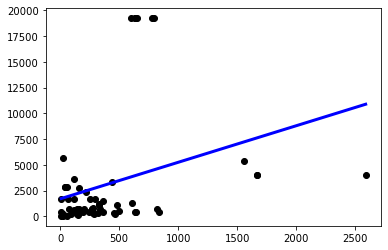

In [16]:
testTraf_Regre=compTraficMesureEstimeTot.loc[(compTraficMesureEstimeTot.SEC==16) & (~compTraficMesureEstimeTot.tmjo_2_sen.isna())].copy().sort_values('tmja')
train_X=[[a[1]]  for a in testTraf_Regre[['tmja','tmjo_2_sen' ]].to_records() ]
train_Y=[[a[2]]  for a in testTraf_Regre[['tmja','tmjo_2_sen']].to_records() ]
test_X=[[t] for t  in testTraf_Regre.tmja.tolist()]
test_Y=[[t] for t  in testTraf_Regre.tmjo_2_sen.tolist()]
regr = linear_model.LinearRegression()
regr.fit(train_X, train_Y)
y_pred = regr.predict(test_X)
plt.scatter(train_X, train_Y,  color='black')
plt.plot(test_X, y_pred, color='blue', linewidth=3)

alpha = 0.1
lasso = Lasso(alpha=alpha)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(train_Y, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(test_Y, y_pred))

y_pred_lasso = lasso.fit(train_X, train_Y).predict(test_X)
r2_score_lasso = r2_score(test_Y, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)

In [98]:
compTraficMesureEstimeTot
X_test=[[a] for a in compTraficMesureEstimeTot.loc[compTraficMesureEstimeTot.tmjo_2_sen.isna() & (compTraficMesureEstimeTot.SEC==16)].tmja.to_numpy()][:60]
X_train=[[a] for a in compTraficMesureEstimeTot.loc[~compTraficMesureEstimeTot.tmjo_2_sen.isna()& (compTraficMesureEstimeTot.SEC==16)].tmja.to_numpy()]
y=[[a] for a in compTraficMesureEstimeTot.loc[~compTraficMesureEstimeTot.tmjo_2_sen.isna()& (compTraficMesureEstimeTot.SEC==16)].rapMesCalc.to_numpy()]
qt = preprocessing.QuantileTransformer(n_quantiles=20,output_distribution='normal', random_state=0)
X_train_qt = qt.fit_transform(X_train)
X_test_qt= qt.fit_transform(X_test)
X_train_scaled = preprocessing.scale(X_train)
X_test_scaled = preprocessing.scale(X_test)
X_train_scaled_qt=qt.fit_transform(X_train_scaled)
X_test_scaled_qt=qt.fit_transform(X_test_scaled)

In [107]:
svr_rbf = SVR(kernel='rbf', C=1)
svr.fit(X_train_scaled_qt, [a[0] for a in y])
svr.predict(X_test_scaled_qt)

array([0.07115203, 0.3103084 , 0.31016297, 0.31028631, 0.31018185,
       0.31024375, 0.31377854, 0.31193255, 0.31074416, 0.31030672,
       0.30858993, 0.31032332, 0.31024015, 0.31046868, 0.30935126,
       0.30812339, 0.31036545, 0.31030859, 0.31030732, 0.31030789,
       0.31236963, 0.31188764, 0.3112868 , 0.31003676, 0.31030791,
       0.31002842, 0.30266163, 0.31045031, 0.5494638 , 0.32501705,
       0.31801635, 0.31072195, 0.31052611, 0.30963556, 0.30795306,
       0.30859132, 0.30572492, 0.31027123, 0.30977249, 0.31795819,
       0.31074847, 0.31029584, 0.30298929, 0.30901414, 0.31035591,
       0.31038399, 0.30647072, 0.31030743, 0.31073211, 0.31476457,
       0.3133752 , 0.3122238 , 0.30947927, 0.30997588, 0.310316  ,
       0.31098451, 0.2989364 , 0.31367286, 0.30481617, 0.310321  ])

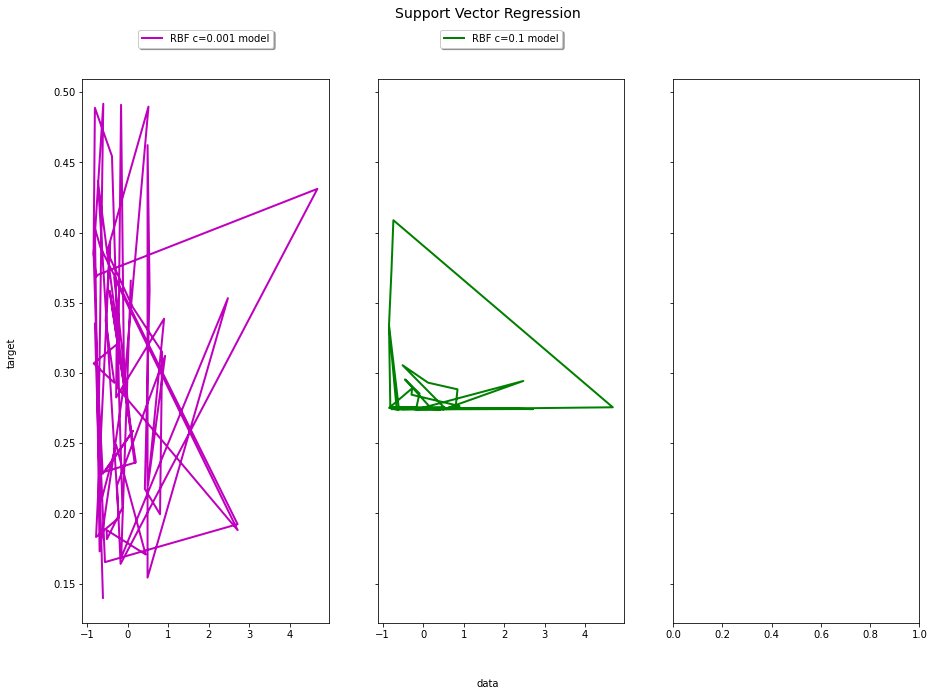

In [105]:
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=1)
svr_poly = SVR(kernel='poly', C=1 )
# Look at the results
lw = 2

svrs = [svr_rbf,svr_poly]
kernel_label = ['RBF c=0.001','RBF c=0.1']
model_color = ['m', 'g']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10), sharey=True)
for ix, svr in enumerate(svrs):
    axes[ix].plot(X_train_scaled, svr.fit(X_train_scaled, [a[0] for a in y]).predict(X_test_scaled), color=model_color[ix], lw=lw,
                  label='{} model'.format(kernel_label[ix]))
    axes[ix].legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
                    ncol=1, fancybox=True, shadow=True)

fig.text(0.5, 0.04, 'data', ha='center', va='center')
fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
fig.suptitle("Support Vector Regression", fontsize=14)
plt.show()

In [23]:
compTraficMesureEstimeTot.iloc[:633]['test1']=svr.fit(X_train_qt, [a[0] for a in y]).predict(X_test_qt)

c:\users\marti\appdata\local\programs\python\python38\lib\site-packages\geopandas\geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [90]:
compTraficMesureEstimeTot.loc[compTraficMesureEstimeTot.tmjo_2_sen.isna(),'IA_test']=svr.predict(X_test)

In [91]:
compTraficMesureEstimeTot

,ident,tmjo_2_sen,id_cpt_exp,geometry,trajet_court,SEC,nbDeplacementPop,PopT2016,nb_traj_moyPop,nbDeplacementActivite,effectifMoyen,nb_moy_trajet_pers,ratio_trajet_motorise,tmja,rapMesCalc,IA_test
0,8146.0,1370.0,"72, 73","LINESTRING Z (417591.040 6424518.690 0.000, 41...",8146,2,1450.038992,2207.932425,0.656741,352.500000,235.0,2.621212,0.572254,1802.538992,1.315722,NaN
1,7591.0,573.0,"850, 851","LINESTRING Z (415922.490 6422820.160 0.000, 41...",7591,2,48.513248,73.869720,0.656741,0.000000,0.0,0.000000,0.000000,48.513248,0.084665,NaN
2,19916.0,856.0,"184, 183","LINESTRING Z (422670.940 6427576.980 0.000, 42...",19916,13,376.097524,250.226327,1.503029,0.000000,0.0,0.000000,0.000000,376.097524,0.439366,NaN
3,20546.0,365.0,"1867, 1868","LINESTRING Z (414842.000 6413435.580 0.000, 41...",20546,19,102.969153,62.801336,1.639601,0.000000,0.0,0.000000,0.000000,102.969153,0.282107,NaN
4,35430.0,975.0,"1155, 1156","LINESTRING Z (413654.410 6431690.650 0.000, 41...",35430,15,542.694857,297.491623,1.824236,8.444444,4.0,2.666667,0.791667,551.139301,0.565271,NaN
5,19921.0,450.0,"910, 911","LINESTRING Z (423636.370 6427679.340 0.000, 42...",19921,13,86.390424,57.477535,1.503029,2.176471,1.0,2.941176,0.740000,88.566895,0.196815,NaN
6,1236.0,1214.0,126,"LINESTRING Z (420006.830 6419556.380 0.000, 41...",1236,11,826.061561,672.074632,1.229122,75.310345,42.0,2.310345,0.776119,901.371906,0.742481,NaN
7,6560.0,436.0,1308,"LINESTRING Z (419118.780 6424082.750 0.000, 41...",6560,6,30.266983,36.996281,0.818109,42.411765,28.0,2.500000,0.605882,72.678748,0.166694,NaN
8,52232.0,1902.0,"1611, 1612","LINESTRING Z (417998.740 6415851.410 0.000, 41...",52232,11,1102.685592,897.132912,1.229122,30.482759,17.0,2.310345,0.776119,1133.168350,0.595777,NaN
9,52232.0,1902.0,"1611, 1612","LINESTRING Z (417998.740 6415851.410 0.000, 41...",52232,11,1102.685592,897.132912,1.229122,32.500000,15.0,2.733333,0.792683,1135.185592,0.596838,NaN
